In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [2]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import xarray as xr
import mlflow

/var/folders/vm/9ws15vws62zgnr64rdr_ls5r0000gn/T/ipykernel_91293/4025213481.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


# Load the datasets

The modelling will use the following datasets:
- Digital Surface Model (DSM) & Digital Terrain Model (DTM) to derive a canopy height model (CHM) which is a key feature in predicting vegetation height
- Sentinel-2 (S2) imagery to classify pixels as vegetation or non-vegetation
- Vegetation height data from the Environment Agency (EA) to train the model. This data has gaps so can't be used directly.

In [3]:
dtm = rxr.open_rasterio('data/processed/dtm-10m.tif')
dsm = rxr.open_rasterio('data/processed/dsm-10m.tif')
veg_height = rxr.open_rasterio('data/processed/vegetation-height.tif')

In [4]:
# Sentinel-2
sentinel_2 = xr.open_mfdataset('data/raw/big-files/sentinel-2/*.tif', combine='by_coords', engine="rasterio")
sentinel_2

<xarray.Dataset>
Dimensions:      (band: 12, x: 10647, y: 8294)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float64 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [5]:
# From earth engine
band_names = list(sentinel_2.band_data.attrs['long_name'])
sentinel_2 = sentinel_2.band_data.to_dataset(dim='band').rename({i + 1: "s2_" + band_names[i] for i in range(12)})
sentinel_2

<xarray.Dataset>
Dimensions:      (y: 8294, x: 10647)
Coordinates:
  * x            (x) float64 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
Data variables:
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B7        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8A       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

# No Data Values

In [6]:
# Convert the nodata values to np.nan and write them for each dataset variable


def write_nodata(array):
    nodata_value = array.rio.nodata
    if nodata_value is not None:
        array = array.where(array != nodata_value, np.nan)
    # set dtype to float32
    array = array.astype(np.float32)
    array.rio.write_nodata(np.nan, inplace=True)
    return array

sentinel_2_arr = sentinel_2.to_array()
sentinel_2_arr = write_nodata(sentinel_2_arr)
sentinel_2 = sentinel_2_arr.to_dataset(dim='variable')

dtm = write_nodata(dtm)
dsm = write_nodata(dsm)
veg_height = write_nodata(veg_height)



# Align the Rasters

To model the data the rasters all need to be aligned so that a pixel in one raster corresponds to the same location as a pixel in another raster.

In [7]:
veg_height = veg_height.rio.reproject_match(sentinel_2)
dsm = dsm.rio.reproject_match(sentinel_2)
dtm = dtm.rio.reproject_match(sentinel_2)

# Drop the band dimension 
veg_height = veg_height.squeeze()
dsm = dsm.squeeze()
dtm = dtm.squeeze()

The arrays need to be converted to datasets with variable names and then stacked with the sentinel image.

In [8]:
dsm = dsm.to_dataset(name='dsm')
dtm = dtm.to_dataset(name='dtm')
veg_height = veg_height.to_dataset(name='veg_height')

In [9]:
image_stack = xr.merge([sentinel_2, dsm, dtm, veg_height])

In [10]:
image_stack

<xarray.Dataset>
Dimensions:      (y: 8294, x: 10647)
Coordinates:
  * x            (x) float64 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
    band         int64 1
Data variables: (12/15)
    s2_B1        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...           ...
    s2_B9        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dsm          (y, x) float32 167.6 170.4 168.2 170.0 ... 27.49 27.32 27.18
    dtm          (y, x) float32 166.7 166.3 165.7 165.8 ... 27.49 27.32 27.18
    veg_height   (y, x) float32 0.03893 4.475 0.01682 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...
    _FillValue:     nan

# Create the training dataset

Write the data out to a file. The data needds to be in two seperate rasters. One for the veg height (y - what I want to predict), the other for the lidar and sentinel-2 data (X - my prediction inputs).

In [11]:
image_stack["is_veg"] = (image_stack["veg_height"] > 0).astype(int)

In [13]:
image_stack['chm'] = image_stack['dsm'] - image_stack['dtm']

In [14]:
# Select some variables
image_stack = image_stack[['s2_B3', 's2_B4', 's2_B5', 's2_B6', 's2_B7', 's2_B8A', 'chm', 'veg_height', 'is_veg']]

In [15]:
len(['s2_B3', 's2_B4', 's2_B5', 's2_B6', 's2_B7', 's2_B8A', 'chm', 'veg_height', 'is_veg'])

9

In [16]:
image_stack.attrs['long_name'] = tuple(image_stack.data_vars.keys())
image_stack.to_array().rio.to_raster('data/processed/s2-lidar/s2-lidar-stack.tif', compress='lzw')

# Mask

In [16]:
image_stack

<xarray.Dataset>
Dimensions:      (y: 8294, x: 10647)
Coordinates:
  * x            (x) float64 3.908e+05 3.908e+05 ... 4.973e+05 4.973e+05
  * y            (y) float64 4.403e+05 4.403e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
    band         int64 1
Data variables:
    s2_B3        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B7        (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8A       (y, x) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    chm          (y, x) float32 0.889 4.117 2.559 ... 4.768e-05 -1.907e-06
    veg_height   (y, x) float32 0.03893 4.475 0.01682 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('s2_B3', 's2_B4', 's2_B5', 's2_B6', 's2_B7', 's2_B8A', '...
    _FillValue:     nan

This code works out where the missing values are in the dataset

In [17]:
image_stack.rio.resolution()

(10.0, -10.0)

In [36]:
from sdm.config import tile_size

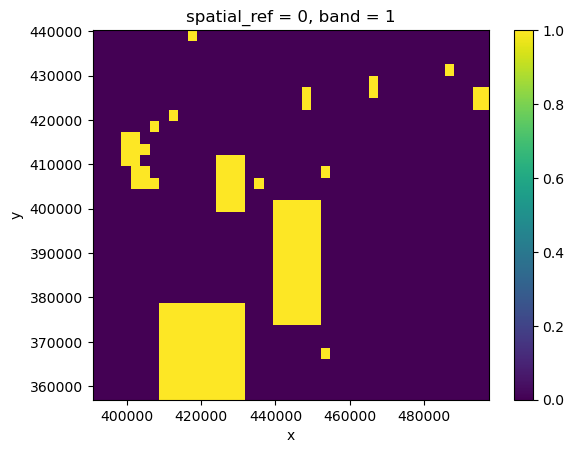

In [37]:
# Generate a mask to represent the areas where there is na or inf values
image_stack_array = image_stack.to_array()

mask = image_stack_array.isnull().any(dim='variable') | np.isinf(image_stack_array).any(dim='variable')

mask_resolution = mask.rio.resolution()[0]

target_resolution = tile_size[0] * mask_resolution

# Target resolution
mask_coarse = mask.coarsen(x = tile_size[0], y = tile_size[1], boundary="pad").mean().compute()
mask_coarse = mask_coarse > 0
mask_coarse.plot()

In [38]:
mask_df = mask_coarse.to_dataframe(name='missing_values')
mask_df.reset_index(inplace=True)
mask_df["resolution_x"] = target_resolution
mask_df["resolution_y"] = target_resolution
mask_df["xmin"] = mask_df.x 
mask_df["ymin"] = mask_df.y
mask_df["xmax"] = mask_df.x + mask_df.resolution_x
mask_df["ymax"] = mask_df.y + (mask_df.resolution_y)
mask_df = mask_df.drop(columns=['x', 'y', "band", "spatial_ref"])
mask_df = mask_df[~mask_df.missing_values]

mask_df.to_csv("data/processed/s2-lidar/valid-bounding-boxes.csv", index=False)
mask_df

,missing_values,resolution_x,resolution_y,xmin,ymin,xmax,ymax
0,False,2560.0,2560.0,392080.0,438990.0,394640.0,441550.0
1,False,2560.0,2560.0,394640.0,438990.0,397200.0,441550.0
2,False,2560.0,2560.0,397200.0,438990.0,399760.0,441550.0
3,False,2560.0,2560.0,399760.0,438990.0,402320.0,441550.0
4,False,2560.0,2560.0,402320.0,438990.0,404880.0,441550.0
...,...,...,...,...,...,...,...
1381,False,2560.0,2560.0,486800.0,357840.0,489360.0,360400.0
1382,False,2560.0,2560.0,489360.0,357840.0,491920.0,360400.0
1383,False,2560.0,2560.0,491920.0,357840.0,494480.0,360400.0
1384,False,2560.0,2560.0,494480.0,357840.0,497040.0,360400.0
